In [1]:
import urllib 

import pandas as pd
import numpy as np 

import dask.dataframe as dd
import dask.bag as db
import dask.diagnostics as dg

## figure out which stations we need

In [2]:
# {column name:extents of the fixed-width fields}
columns = {"ID": (0,11), "LATITUDE": (12, 20), "LONGITUDE": (21, 30), "ELEVATION": (31, 37),"STATE": (38, 40),
           "NAME": (41, 71), "GSN FLAG": (72, 75), "HCN/CRN FLAG": (76, 79),"WMO ID": (80, 85)}

In [3]:
df = pd.read_fwf("http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt", 
                    colspecs=list(columns.values()), names=list(columns.keys()),
                    dtype={'ID': str, 'LATITUDE':float, 'LONGITUDE':float, 
                           'ELEVATION':float, 'STATE':str, 'NAME':str, 
                           'GSN FLAG': str, 'HCN/CRN FLAG': str, 'WMO ID':str})

In our documentation sheet https://docs.opendata.aws/noaa-ghcn-pds/readme.html
ID = the station identification code.
* The first two characters denote the FIPS country code
So we're going to use that to get all the US Station IDs, but first we're going to check what it returns, which 
is states + DC + PR + VI

In [4]:
df[df['ID'].str.startswith('US')]['STATE'].unique()

array(['SD', 'CO', 'NE', 'AK', 'AL', 'AR', 'AZ', 'CA', 'TN', 'CT', 'DC',
       'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA',
       'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NH',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'PI', 'UM'], dtype=object)

In [5]:
# So lets get all the US country codes where the STATE is not in ['PR', 'VI'] 'cause it's easier to map
# Also we need a WMO ID 'cause thats how we cross reference against mos
# this is just a check that our filter is correct

In [6]:
mask = (df['ID'].str.startswith('US') & ~ df['STATE'].isin(['PR', 'VI']) & ~df['WMO ID'].isnull())
df[mask]['STATE'].unique()

array(['AZ', 'FL', 'GA', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MO',
       'MT', 'NH', 'SD', 'TX', 'UT', 'VT', 'WA', 'WI', 'AK', 'HI', 'CA',
       'CO', 'NM', 'OK', 'KS', 'NV', 'SC', 'WV', 'VA', 'NC', 'PA', 'KY',
       'TN', 'AL', 'LA', 'MS', 'AR', 'OR', 'ID', 'WY', 'NY', 'DE', 'IN',
       'OH', 'NJ', 'CT', 'RI', 'ND', 'NE'], dtype=object)

In [7]:
df[mask]

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
88311,USC00026180,36.9208,-111.4483,1301.5,AZ,PAGE,NaN,NaN,72378
90722,USC00080211,29.7258,-85.0206,6.1,FL,APALACHICOLA AIRPORT,NaN,HCN,72220
91014,USC00088782,27.7053,-82.4008,12.2,FL,TAMPA BAY AREA WFO,NaN,NaN,72210
91103,USC00091544,31.8667,-81.6167,27.1,GA,FT STEWART,NaN,NaN,74780
91191,USC00093538,31.8694,-81.6236,28.0,GA,FT STEWART,NaN,NaN,74780
...,...,...,...,...,...,...,...,...,...
114296,USW00094996,40.6953,-96.8542,418.2,NE,LINCOLN 11 SW,NaN,CRN,74441
114297,USW00096404,62.7369,-141.2083,609.6,AK,TOK 70 SE,NaN,CRN,70292
114299,USW00096406,64.5014,-154.1297,78.9,AK,RUBY 44 ESE,NaN,CRN,70224
114300,USW00096407,66.5620,-159.0036,6.7,AK,SELAWIK 28 E,NaN,CRN,70170


In [8]:
# we're getting the list of US unique stations
us_stations = df[mask]
len(us_stations['ID'])

666

In [9]:
us_stations.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
88311,USC00026180,36.9208,-111.4483,1301.5,AZ,PAGE,NaN,NaN,72378
90722,USC00080211,29.7258,-85.0206,6.1,FL,APALACHICOLA AIRPORT,NaN,HCN,72220
91014,USC00088782,27.7053,-82.4008,12.2,FL,TAMPA BAY AREA WFO,NaN,NaN,72210
91103,USC00091544,31.8667,-81.6167,27.1,GA,FT STEWART,NaN,NaN,74780
91191,USC00093538,31.8694,-81.6236,28.0,GA,FT STEWART,NaN,NaN,74780


### Lets sample that!
Do we really need all our stations?

In [10]:
import geopandas as gpd

In [11]:
gdf = gpd.GeoDataFrame(us_stations, geometry=gpd.points_from_xy(us_stations['LONGITUDE'], us_stations['LATITUDE']))

<AxesSubplot:>

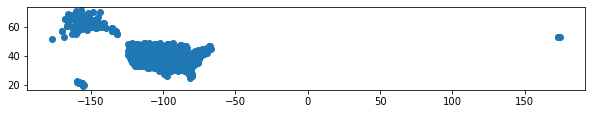

In [12]:
gdf.plot(figsize=(10,5))

let's find those outliers by looking at the longitude

In [13]:
gdf.sort_values('LONGITUDE', ascending=False).head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID,geometry
113706,USW00045715,52.7167,174.1000,37.2,AK,SHEMYA USAF BASE,NaN,NaN,70414,POINT (174.10000 52.71670)
109028,USC00500452,52.8333,173.1833,21.3,AK,ATTU,NaN,NaN,70409,POINT (173.18330 52.83330)
113704,USW00045709,52.8000,173.1667,28.0,AK,ATTU NS,NaN,NaN,70409,POINT (173.16670 52.80000)
94657,USC00172426,44.9067,-66.9919,25.9,ME,EASTPORT,NaN,HCN,72608,POINT (-66.99190 44.90670)
114215,USW00094645,46.9600,-67.8833,224.6,ME,LIMESTONE 4 NNW,NaN,CRN,72710,POINT (-67.88330 46.96000)


<AxesSubplot:>

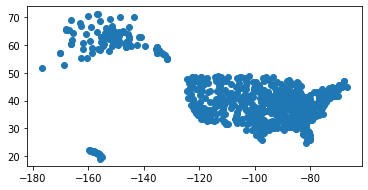

In [14]:
# let's drop them:
gdf_w = gdf[gdf['LONGITUDE']<0]
gdf_w.plot()

We really don't need that dense of a network of plots, let's sample by 10 percent and see what happens

<AxesSubplot:>

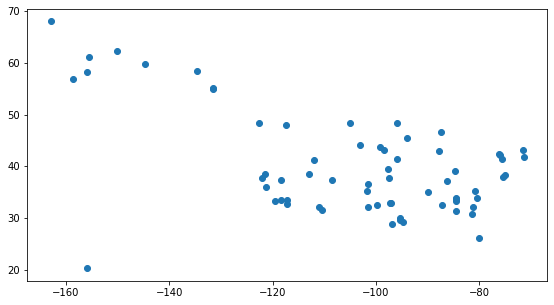

In [15]:
gdf_w.sample(frac=.10).plot(figsize=(10,5))

<AxesSubplot:>

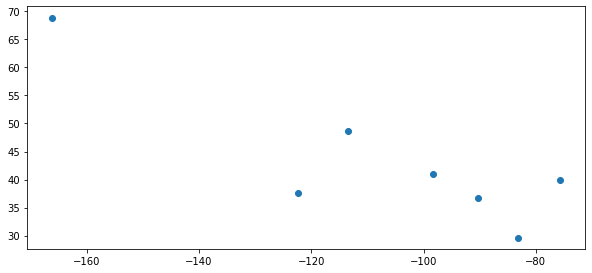

In [16]:
#1% which is about 6 stations
gdf_w.sample(frac=.01).plot(figsize=(10,5))

In [17]:
# try your own 
frac = ?
gdf_w.sample(frac=frac).plot(figsize=(10,5))

SyntaxError: invalid syntax (<ipython-input-17-0fd1e2a8b2d0>, line 2)

In [18]:
# lets use the 60 stations from our sample to filter down our dataset
us_stations = gdf_w.sample(frac=.1)['ID']

## Filter MOS down to our sample set of stations
OUR MOS codes aren't matching up w/ our WMO above so we're gonna find the nearest neighbors to the above stations
This is a spreadsheet of where the mos stations are 

In [19]:
mdf = pd.read_csv("https://www.weather.gov/source/mdl/tables/MOS_stationtable_20190702.csv")

In [20]:
# us stations only have 4 values
mosdf = mdf[mdf['Station'].str.len()==4]

In [21]:
mgdf = gpd.GeoDataFrame(mosdf,geometry=gpd.points_from_xy(mosdf['Longitude'], mosdf['Latitude']))

In [22]:
len(mgdf['Station'].unique())

2113

## Let's find our nearest neighbor
https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe/222316

In [23]:
# compute distance between each station and all the others
def distance(row):
    return mgdf['geometry'].distance(row['geometry'])
    
distances = gdf_w.apply(distance, axis=1)

In [24]:
distances.shape # rows in gdf_w x rows in mgdf

(663, 2113)

In [25]:
# get the id of the closet station by finding the index of the station with the minimum distance
# and then create a new column in our gdf_w with the closest MOS station
stationloc = np.argmin(distances.values,axis=1)

In [26]:
stationloc.shape, mgdf.shape, gdf_w.shape

((663,), (2113, 8), (663, 10))

In [28]:
# from mgdf pull the station closest in distance to the gdf station for that row
gdf_w['neighbor'] = mgdf.iloc[stationloc]['Station'].values
gdf_w['distance'] = distances.min(axis=1)

In [29]:
# this is our lookup comparison
gdf_w[['ID', 'neighbor']].head()

,ID,neighbor
88311,USC00026180,KPGA
90722,USC00080211,KAAF
91014,USC00088782,KMCF
91103,USC00091544,KLHW
91191,USC00093538,KLHW


In [30]:
#lets merge in the mgdf since we're going to end up wanting the center lat/lon for plotting
gdmo = gdf_w.merge(mgdf, left_on = 'neighbor', right_on='Station', suffixes=('_ghcn', '_mos'))

In [31]:
gdmo.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID,geometry_ghcn,neighbor,distance,Station,Station Name,State/Region,Latitude,Longitude,Elevation(ft),Products,geometry_mos
0,USC00026180,36.9208,-111.4483,1301.5,AZ,PAGE,NaN,NaN,72378,POINT (-111.44830 36.92080),KPGA,0.012615,KPGA,PAGE ASOS,AZ,36.9333,-111.4500,4278,mex mav00 mav06 mav12 mav18 rfc met,POINT (-111.45000 36.93330)
1,USW00003162,36.9261,-111.4478,1313.7,AZ,PAGE MUNI AP,NaN,NaN,72371,POINT (-111.44780 36.92610),KPGA,0.007529,KPGA,PAGE ASOS,AZ,36.9333,-111.4500,4278,mex mav00 mav06 mav12 mav18 rfc met,POINT (-111.45000 36.93330)
2,USC00080211,29.7258,-85.0206,6.1,FL,APALACHICOLA AIRPORT,NaN,HCN,72220,POINT (-85.02060 29.72580),KAAF,0.008453,KAAF,APALACHICOLA,FL,29.7333,-85.0167,20,mex mav00 mav06 mav12 mav18 met,POINT (-85.01670 29.73330)
3,USW00012832,29.7333,-85.0333,5.8,FL,APALACHICOLA AP,NaN,NaN,72220,POINT (-85.03330 29.73330),KAAF,0.016600,KAAF,APALACHICOLA,FL,29.7333,-85.0167,20,mex mav00 mav06 mav12 mav18 met,POINT (-85.01670 29.73330)
4,USC00088782,27.7053,-82.4008,12.2,FL,TAMPA BAY AREA WFO,NaN,NaN,72210,POINT (-82.40080 27.70530),KMCF,0.175439,KMCF,MAC DILL AFB,FL,27.8500,-82.5000,13,mex mav00 mav06 mav12 mav18 met,POINT (-82.50000 27.85000)


In [32]:
#let's save out what we need:
gdmo[['ID', 'LATITUDE', 'LONGITUDE', 'Station', 'Latitude', 'Longitude']].to_csv("ghcn_mos_lookup.csv")

## Filter GHCN down to our sample set of stations & variables

In [33]:
# the above lines up w/ mos, let's filter GHCN down to the us_stations
YEAR = 2017
names = ['ID', 'DATE', 'ELEMENT', 'DATA_VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME']
ds = dd.read_csv(f's3://noaa-ghcn-pds/csv/{YEAR}.csv', storage_options={'anon':True},  
                 names=names, dtype={'DATA_VALUE':'object'})

* PRCP = Precipitation (tenths of mm)
* TMAX = Maximum temperature (tenths of degrees C)
* TMIN = Minimum temperature (tenths of degrees C)

In [45]:
# Here we're filtering to just the rows where these conditions are met
dsus = ds[ds['ID'].isin(gdmo['ID']) & ds['ELEMENT'].isin(['PRCP', 'TMAX', 'TMIN'])]
dsus.head()

,ID,DATE,ELEMENT,DATA_VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME
50300,USC00088782,20170101,TMAX,283,NaN,NaN,7,2400.0
50301,USC00088782,20170101,TMIN,133,NaN,NaN,7,2400.0
50303,USC00088782,20170101,PRCP,0,NaN,NaN,7,2400.0
50536,USC00093538,20170101,TMAX,239,NaN,NaN,7,1600.0
50537,USC00093538,20170101,TMIN,78,NaN,NaN,7,1600.0


In [46]:
# Lets only get the columns we want
dsus_subset = dsus[['ID', 'DATE', 'ELEMENT', 'DATA_VALUE',  'M-FLAG', 'Q-FLAG']]
dsus_subset.head()

,ID,DATE,ELEMENT,DATA_VALUE,M-FLAG,Q-FLAG
50300,USC00088782,20170101,TMAX,283,NaN,NaN
50301,USC00088782,20170101,TMIN,133,NaN,NaN
50303,USC00088782,20170101,PRCP,0,NaN,NaN
50536,USC00093538,20170101,TMAX,239,NaN,NaN
50537,USC00093538,20170101,TMIN,78,NaN,NaN


In [ ]:
# let's save out to a single largeish CSV, 
sample = 100
dsus.compute().to_csv(f"GHCN_{YEAR}.csv")

## Filter MOS down to just stations in our lookup

In [55]:
columns = ['station', 'short_model', 'model', 'runtime', 'ftime', 'N/X', 'X/N',
           'TMP', 'DPT', 'WDR', 'WSP', 'CIG', 'VIS', 'P06', 'P12', 'POS', 'POZ',
           'SNW', 'CLD', 'OBV', 'TYP', 'Q06', 'Q12', 'T06', 'T12']
mos = dd.read_csv(f'mos/modelrun/mav{YEAR}*.csv', names=columns)

In [56]:
mos.head()

,station,short_model,model,runtime,ftime,N/X,X/N,TMP,DPT,WDR,...,POS,POZ,SNW,CLD,OBV,TYP,Q06,Q12,T06,T12
0,KCVH,GFS,GFS MOS GUIDANCE,2017-04-03 06:00:00+00:00,2017-04-03 12:00:00,NaN,NaN,47,45,18,...,0,0,NaN,CL,N,R,NaN,NaN,NaN,NaN
1,KCVH,GFS,GFS MOS GUIDANCE,2017-04-03 06:00:00+00:00,2017-04-03 15:00:00,NaN,NaN,47,46,6,...,5,0,NaN,CL,N,R,NaN,NaN,NaN,NaN
2,KCVH,GFS,GFS MOS GUIDANCE,2017-04-03 06:00:00+00:00,2017-04-03 18:00:00,NaN,NaN,62,47,2,...,0,0,NaN,CL,N,R,0.0,NaN,0/ 0,NaN
3,KCVH,GFS,GFS MOS GUIDANCE,2017-04-03 06:00:00+00:00,2017-04-03 21:00:00,NaN,NaN,75,44,26,...,5,0,NaN,CL,N,R,NaN,NaN,NaN,NaN
4,KCVH,GFS,GFS MOS GUIDANCE,2017-04-03 06:00:00+00:00,2017-04-04 00:00:00,NaN,78.0,74,45,24,...,0,0,NaN,CL,N,R,0.0,0.0,1/ 0,NaN


In [57]:
# row filters
mosus = mos[mos['station'].isin(gdmo['Station'])]

* N/X = nighttime minimum/daytime maximum surface temperatures.
* TMP = surface temperature valid at that hour.
* Q06 = quantitative precipitation forecast (QPF) category for liquid equivalent precipitation amount during a 6-h period ending at that time.
* Q12 = QPF category for liquid equivalent precipitation amount during a 12-h period ending at the indicated time.
     

In [59]:
# column filter
mosv = mosus[['station', 'runtime', 'ftime', 'N/X', 'X/N','Q06', 'Q12']]

In [60]:
# save to csv , compute turns it to a dataframe so we only have 1 file to worry about
mosv.compute().to_csv(f"MOS_{YEAR}.csv")